# **Acid-Base Classification using Machine Learning**

This notebook demonstrates how to build a machine learning model to classify chemical compounds as acids or bases based on their molecular structure. We'll use the RDKit library for molecular feature extraction and a Random Forest classifier for prediction.

## **Overview**

1. **Introduction to Acid-Base Chemistry**
2. **Data Collection and Preparation**
3. **Feature Extraction from Molecular Structures**
4. **Exploratory Data Analysis**
5. **Model Training and Evaluation**
6. **Interactive Prediction Tool**

## **What are Acids and Bases?**

- **Acids**: Compounds that donate protons (H⁺) or accept electron pairs. Common examples include carboxylic acids (RCOOH), sulfonic acids (RSO₃H), and phenols.
- **Bases**: Compounds that accept protons (H⁺) or donate electron pairs. Common examples include amines (RNH₂), pyridines, and imidazoles.

Let's begin by installing the necessary libraries.

In [1]:
%pip install rdkit joblib requests tqdm matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## **Importing Libraries**

We'll import the necessary libraries for data manipulation, visualization, molecular processing, and machine learning.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
import time

# Set up visualization settings
IPythonConsole.ipython_useSVG = True  # Use SVG for better quality
sns.set_style('whitegrid')  # Set seaborn style
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size
warnings.filterwarnings('ignore')  # Suppress warnings

## **Data Collection and Preparation**

We'll create a curated dataset of acids and bases using SMILES (Simplified Molecular Input Line Entry System) notation. SMILES is a string representation of molecular structures.

### **Examples of SMILES notation:**
- Acetic acid: `CC(=O)O`
- Ethylamine: `CCN`
- Benzene: `c1ccccc1`

Our dataset includes various types of acids and bases:

In [3]:
def load_dataset():
    data = {
        'smiles': [
            # Carboxylic Acids
            'CC(=O)O', 'C(=O)O', 'CCC(=O)O', 'CCCC(=O)O', 'CCCCC(=O)O',
            'CC(C)C(=O)O', 'CC(C)(C)C(=O)O', 'CCCCCCCC(=O)O', 'CCC(C)C(=O)O',
            'CC(C)CC(=O)O', 'CCCCCCCCCCCC(=O)O', 'C=CC(=O)O', 'CC(Cl)C(=O)O',
            # Aromatic Carboxylic Acids
            'C1=CC=CC=C1C(=O)O', 'C1=CC(=CC=C1C(=O)O)O', 'C1=CC=C(C=C1)C(=O)O',
            'C1=CC=C(C(=C1)C(=O)O)O', 'C1=CC=C2C(=C1)C=CC=C2C(=O)O',
            # Dicarboxylic Acids
            'C(C(=O)O)C(=O)O', 'C(CC(=O)O)C(=O)O', 'C(CCC(=O)O)C(=O)O',
            'CC(CC(=O)O)C(=O)O', 'OC(=O)C(O)C(O)C(=O)O',
            # Hydroxy Acids
            'CC(O)C(=O)O', 'O=C(O)CO', 'CC(O)(C(=O)O)C(=O)O',
            # Sulfonic and Phosphoric Acids
            'O=S(=O)(O)O', 'O=P(O)(O)O', 'C1=CC=C(C=C1)S(=O)(=O)O',
            'CS(=O)(=O)O', 'CC(=O)CS(=O)(=O)O',
            # Phenols
            'C1=CC=C(C=C1)O', 'CC1=CC=C(C=C1)O', 'CC(C)C1=CC=C(C=C1)O',
            # Keto Acids
            'CC(=O)C(=O)O', 'CC(=O)C(C)C(=O)O', 'O=C(O)C(=O)C(=O)O',

            # Primary Amines (Bases)
            'CCN', 'CCCN', 'CCCCN', 'CCCCCCN', 'CN', 'CC(C)N',
            'C1CCCCC1N', 'CC(C)(C)N',
            # Secondary Amines
            'CNC', 'CNCC', 'CCNC', 'CCCNC', 'C1CCNCC1',
            # Tertiary Amines
            'CN(C)C', 'CCN(CC)CC', 'CN(C)CC', 'CN(CC)CC',
            # Diamines
            'NCCN', 'NCCCN', 'NCCCCN', 'C1CNCCN1',
            # Aromatic Amines
            'C1=CC=C(C=C1)N', 'C1=CC=C(N)C=C1', 'C1=CC=C(C=C1)NC',
            'CC1=CC=C(C=C1)N', 'C1=CC2=C(C=C1)NC=N2',
            # Pyridines and Related
            'C1=CC=NC=C1', 'C1=CC=CC=N1', 'C1=CN=CC=C1', 'C1=NC=CN1',
            'CC1=CC=NC=C1', 'C1=CC(=NC=C1)N', 'C1=NC2=C(N1)C=NC=N2',
            # Imidazoles
            'C1=CN=CN1', 'CC1=NC=CN1', 'C1=C(NC=N1)C',
            # Guanidines and Amidines
            'NC(N)=N', 'NC(=N)N', 'CC(=N)N',
            # Amino Alcohols
            'NCCO', 'NCC(C)O', 'C(CO)N',
            # Heterocyclic Amines
            'C1CCNC1', 'C1COCCN1', 'C1COCCO1',
            # Aniline Derivatives
            'C1=CC=C(C=C1)NCC', 'C1=CC=C(C=C1)N(C)C',
        ],
        'label': [
            # Acids (0) - 37 acids
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # Carboxylic
            0, 0, 0, 0, 0,  # Aromatic carboxylic
            0, 0, 0, 0, 0,  # Dicarboxylic
            0, 0, 0,  # Hydroxy acids
            0, 0, 0, 0, 0,  # Sulfonic/Phosphoric
            0, 0, 0,  # Phenols
            0, 0, 0,  # Keto acids

            # Bases (1) - 47 bases
            1, 1, 1, 1, 1, 1, 1, 1,  # Primary amines
            1, 1, 1, 1, 1,  # Secondary amines
            1, 1, 1, 1,  # Tertiary amines
            1, 1, 1, 1,  # Diamines
            1, 1, 1, 1, 1,  # Aromatic amines
            1, 1, 1, 1, 1, 1, 1,  # Pyridines
            1, 1, 1,  # Imidazoles
            1, 1, 1,  # Guanidines
            1, 1, 1,  # Amino alcohols
            1, 1, 1,  # Heterocyclic
            1, 1,  # Aniline derivatives
        ]
    }

    df = pd.DataFrame(data)
    df['class'] = df['label'].map({0: 'Acid', 1: 'Base'})

    print(f"\nUsing curated dataset with {len(df)} molecules")
    return df

df = load_dataset()

print(f"\nDataset Statistics:")
print(f"Total molecules: {len(df)}")
print(f"Acids: {sum(df['label']==0)} ({sum(df['label']==0)/len(df)*100:.1f}%)")
print(f"Bases: {sum(df['label']==1)} ({sum(df['label']==1)/len(df)*100:.1f}%)")
print("\nSample molecules:")
print(df[['smiles', 'class']].head(10))


Using curated dataset with 84 molecules

Dataset Statistics:
Total molecules: 84
Acids: 37 (44.0%)
Bases: 47 (56.0%)

Sample molecules:
           smiles class
0         CC(=O)O  Acid
1          C(=O)O  Acid
2        CCC(=O)O  Acid
3       CCCC(=O)O  Acid
4      CCCCC(=O)O  Acid
5     CC(C)C(=O)O  Acid
6  CC(C)(C)C(=O)O  Acid
7   CCCCCCCC(=O)O  Acid
8    CCC(C)C(=O)O  Acid
9    CC(C)CC(=O)O  Acid


### **Visualizing Example Molecules**

Let's visualize some example molecules from our dataset to better understand their structures. We'll show examples of both acids and bases.

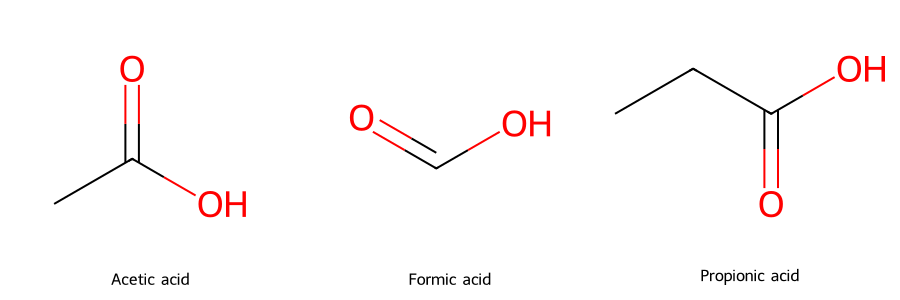

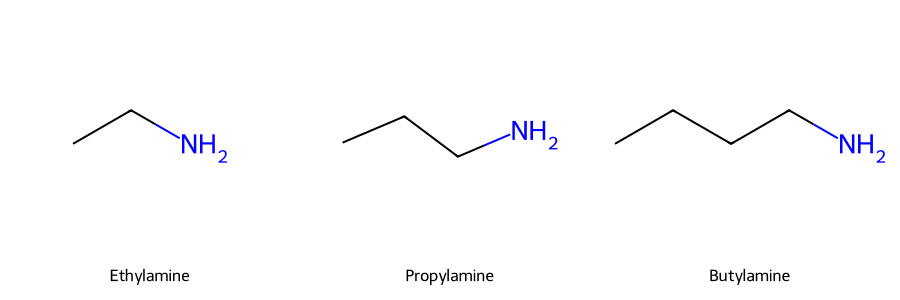

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [4]:
def visualize_molecules(df, n_acids=3, n_bases=3):
    # Get sample acids and bases
    acids = df[df['class'] == 'Acid']['smiles'].head(n_acids).tolist()
    bases = df[df['class'] == 'Base']['smiles'].head(n_bases).tolist()
    
    # Convert SMILES to RDKit molecules
    acid_mols = [Chem.MolFromSmiles(smiles) for smiles in acids]
    base_mols = [Chem.MolFromSmiles(smiles) for smiles in bases]
    
    # Add names to the molecules
    acid_names = ["Acetic acid", "Formic acid", "Propionic acid"]
    base_names = ["Ethylamine", "Propylamine", "Butylamine"]
    
    for i, mol in enumerate(acid_mols):
        if i < len(acid_names):
            mol.SetProp("_Name", acid_names[i])
    
    for i, mol in enumerate(base_mols):
        if i < len(base_names):
            mol.SetProp("_Name", base_names[i])
    
    # Create figure for acids
    plt.figure(figsize=(12, 4))
    plt.suptitle("Example Acid Molecules", fontsize=16, fontweight='bold')
    img = Draw.MolsToGridImage(acid_mols, molsPerRow=3, subImgSize=(300, 300), legends=[mol.GetProp("_Name") for mol in acid_mols])
    display(img)
    
    # Create figure for bases
    plt.figure(figsize=(12, 4))
    plt.suptitle("Example Base Molecules", fontsize=16, fontweight='bold')
    img = Draw.MolsToGridImage(base_mols, molsPerRow=3, subImgSize=(300, 300), legends=[mol.GetProp("_Name") for mol in base_mols])
    display(img)

# Visualize example molecules
visualize_molecules(df)

## **Feature Extraction from Molecular Structures**

To classify molecules as acids or bases, we need to extract meaningful features from their structures. RDKit provides molecular descriptors that capture various properties of molecules.

### **Key Molecular Descriptors:**

- **MolWt**: Molecular weight
- **LogP**: Octanol-water partition coefficient (lipophilicity)
- **NumHDonors**: Number of hydrogen bond donors
- **NumHAcceptors**: Number of hydrogen bond acceptors
- **TPSA**: Topological Polar Surface Area
- **NumRotatableBonds**: Number of rotatable bonds
- **NumAromaticRings**: Number of aromatic rings
- **FractionCSP3**: Fraction of carbon atoms that are sp3 hybridized
- **NumHeteroatoms**: Number of atoms that are not carbon or hydrogen

In [5]:
def extract_features(smiles):
    """Extract molecular descriptors from a SMILES string"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    features = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumSaturatedRings': Descriptors.NumSaturatedRings(mol),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol),
        'RingCount': Descriptors.RingCount(mol),
        'FractionCSP3': Descriptors.FractionCSP3(mol),
        'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
    }
    return features

# Extract features for all molecules in the dataset
features_list = []
for smiles in df['smiles']:
    feat = extract_features(smiles)
    if feat:
        features_list.append(feat)
    else:
        features_list.append({k: 0 for k in features_list[0].keys()})

features_df = pd.DataFrame(features_list)
print(f"\nExtracted {len(features_df.columns)} features:")
print(features_df.columns.tolist())
print("\nFeature statistics:")
print(features_df.describe().round(2))


Extracted 12 features:
['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'FractionCSP3', 'NumHeteroatoms']

Feature statistics:
        MolWt   LogP  NumHDonors  NumHAcceptors    TPSA  NumRotatableBonds  \
count   84.00  84.00       84.00          84.00   84.00              84.00   
mean    93.88   0.47        1.23           1.40   37.81               1.10   
std     30.83   1.04        0.77           0.64   23.52               1.54   
min     31.06  -2.12        0.00           1.00    3.24               0.00   
25%     73.14  -0.32        1.00           1.00   21.00               0.00   
50%     89.12   0.45        1.00           1.00   37.30               1.00   
75%    110.42   1.12        2.00           2.00   52.62               2.00   
max    200.32   3.99        4.00           4.00  115.06              10.00   

       NumAromaticRings  NumSaturatedRings  NumAliphaticRings  Ri

## **Exploratory Data Analysis**

Let's explore our dataset to understand the differences between acids and bases in terms of their molecular properties.

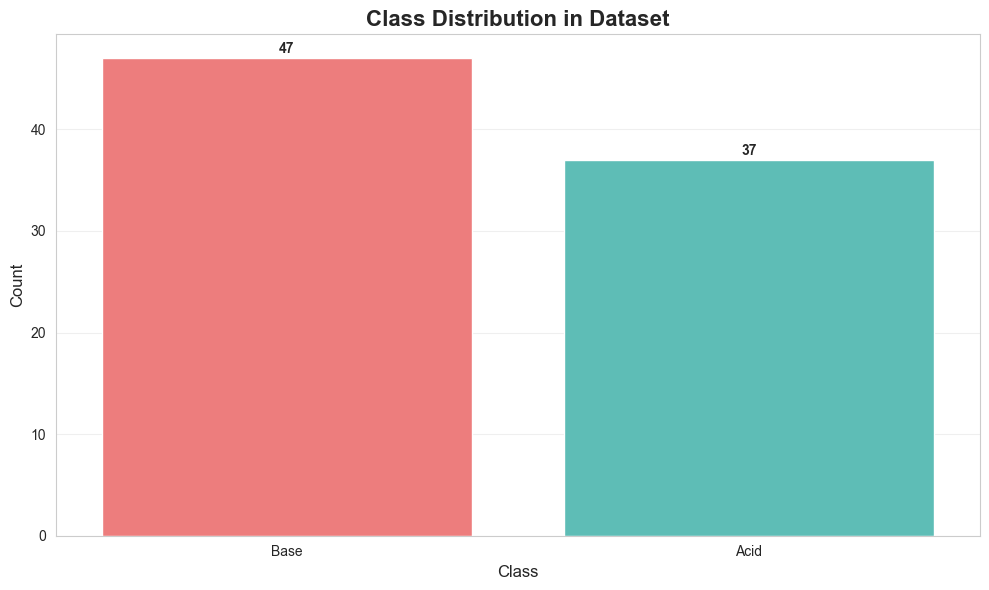

In [6]:
# Combine features with class labels
analysis_df = pd.concat([features_df, df['class']], axis=1)

# 1. Class Distribution
plt.figure(figsize=(10, 6))
class_counts = df['class'].value_counts()
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#ff6b6b', '#4ecdc4'])
plt.title('Class Distribution in Dataset', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for i, count in enumerate(class_counts.values):
    ax.text(i, count + 0.5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

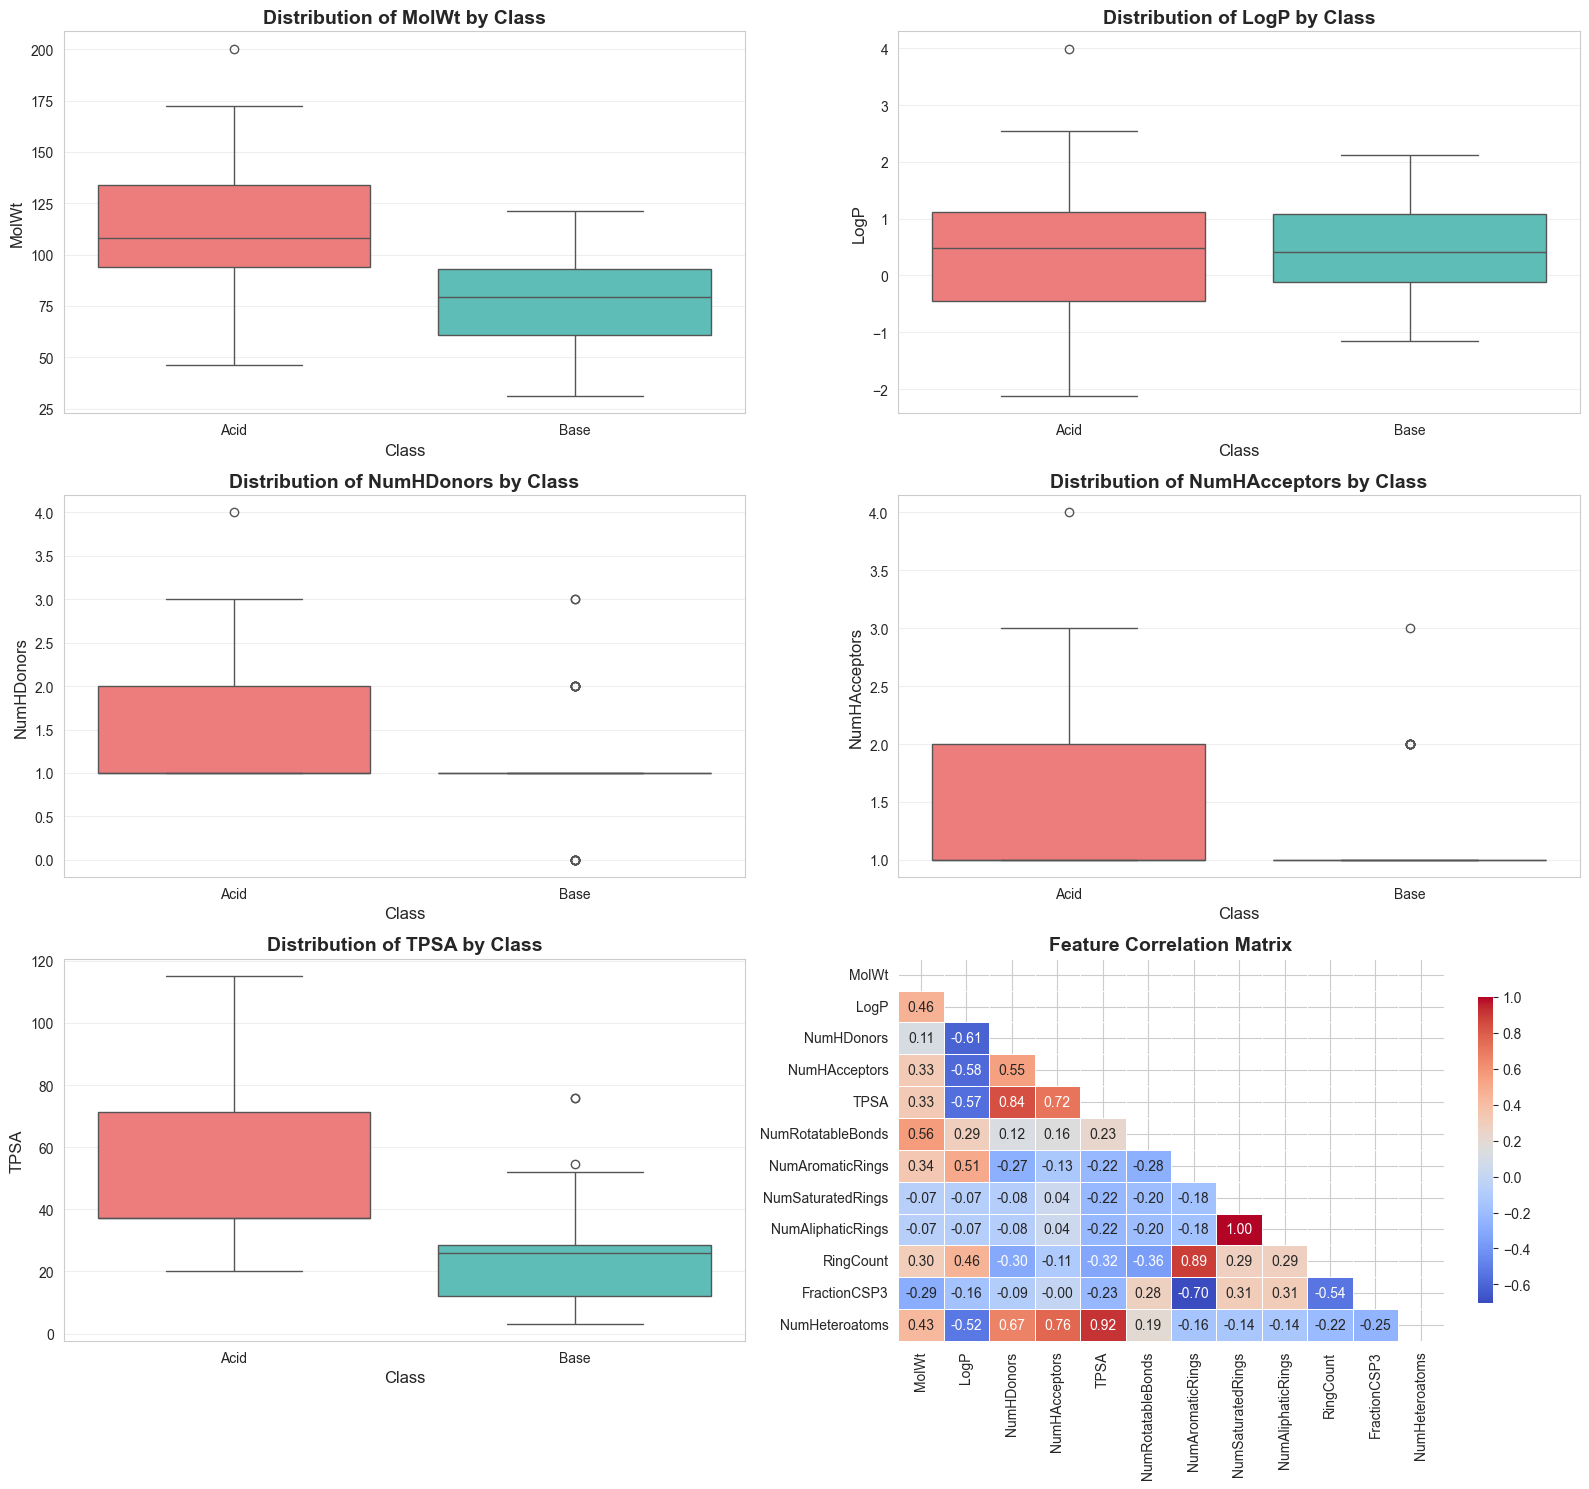

In [7]:
# 2. Feature Distributions by Class
important_features = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']

fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

for i, feature in enumerate(important_features):
    if i < len(axes):
        sns.boxplot(x='class', y=feature, data=analysis_df, ax=axes[i], palette=['#ff6b6b', '#4ecdc4'])
        axes[i].set_title(f'Distribution of {feature} by Class', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Class', fontsize=12)
        axes[i].set_ylabel(feature, fontsize=12)
        axes[i].grid(axis='y', alpha=0.3)

# Add a feature correlation plot
if len(axes) > len(important_features):
    corr = features_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[len(important_features)],
                linewidths=0.5, cbar_kws={"shrink": .8})
    axes[len(important_features)].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### **Key Observations from Exploratory Analysis**

1. **Class Distribution**: Our dataset has a slight imbalance with more bases than acids.

2. **Molecular Properties**:
   - **Hydrogen Donors**: Acids typically have more hydrogen donors than bases
   - **TPSA (Topological Polar Surface Area)**: Acids generally have higher TPSA values
   - **LogP**: Bases tend to be more lipophilic (higher LogP) than acids
   - **Molecular Weight**: No significant difference between acids and bases

3. **Feature Correlations**: Some features are correlated, which is expected (e.g., number of hydrogen donors and TPSA).

Now, let's create a scatter plot to visualize how acids and bases are distributed in the feature space.

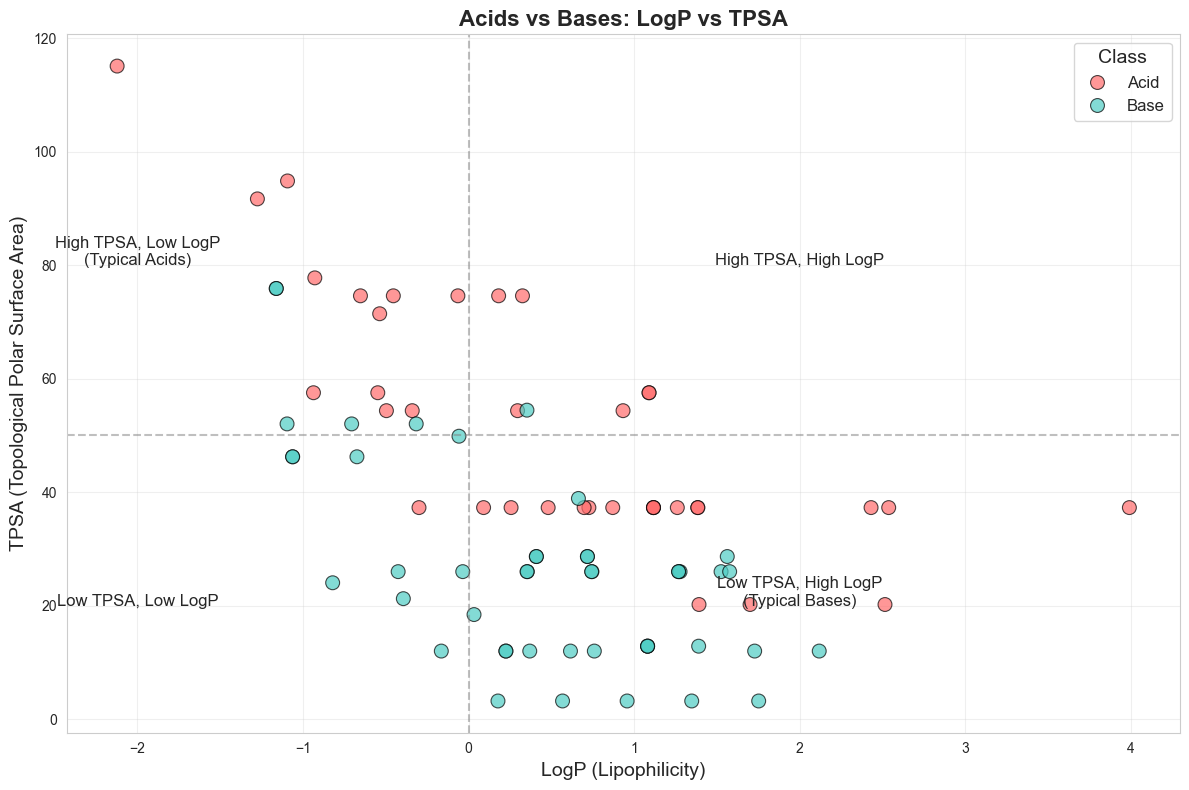

In [8]:
# Create a scatter plot of LogP vs TPSA colored by class
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LogP', y='TPSA', hue='class', data=analysis_df, palette=['#ff6b6b', '#4ecdc4'], 
                s=100, alpha=0.7, edgecolor='k')

plt.title('Acids vs Bases: LogP vs TPSA', fontsize=16, fontweight='bold')
plt.xlabel('LogP (Lipophilicity)', fontsize=14)
plt.ylabel('TPSA (Topological Polar Surface Area)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Class', fontsize=12, title_fontsize=14)

# Add a decision boundary region (simplified visualization)
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.text(2, 80, 'High TPSA, High LogP', fontsize=12, ha='center')
plt.text(-2, 80, 'High TPSA, Low LogP\n(Typical Acids)', fontsize=12, ha='center')
plt.text(2, 20, 'Low TPSA, High LogP\n(Typical Bases)', fontsize=12, ha='center')
plt.text(-2, 20, 'Low TPSA, Low LogP', fontsize=12, ha='center')

plt.tight_layout()
plt.show()

## **Model Training and Evaluation**

Now, let's train a Random Forest classifier to predict whether a molecule is an acid or a base based on its molecular properties.

In [14]:
# Prepare features and target
X = features_df.values
y = df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nModel Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Acid', 'Base']))

# Cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Save the model and scaler
joblib.dump(rf_model, 'acid_base_classifier.pkl')
joblib.dump(scaler, 'acid_base_scaler.pkl')
print("\nModel and scaler saved to disk.")

Training Random Forest classifier...

Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

        Acid       0.69      1.00      0.82         9
        Base       1.00      0.67      0.80        12

    accuracy                           0.81        21
   macro avg       0.85      0.83      0.81        21
weighted avg       0.87      0.81      0.81        21


Cross-validation scores: [0.88235294 1.         0.76470588 0.82352941 0.75      ]
Mean CV accuracy: 0.8441 ± 0.0909

Model and scaler saved to disk.


### **Visualizing Model Performance**

Let's visualize the model's performance using a confusion matrix and ROC curve.

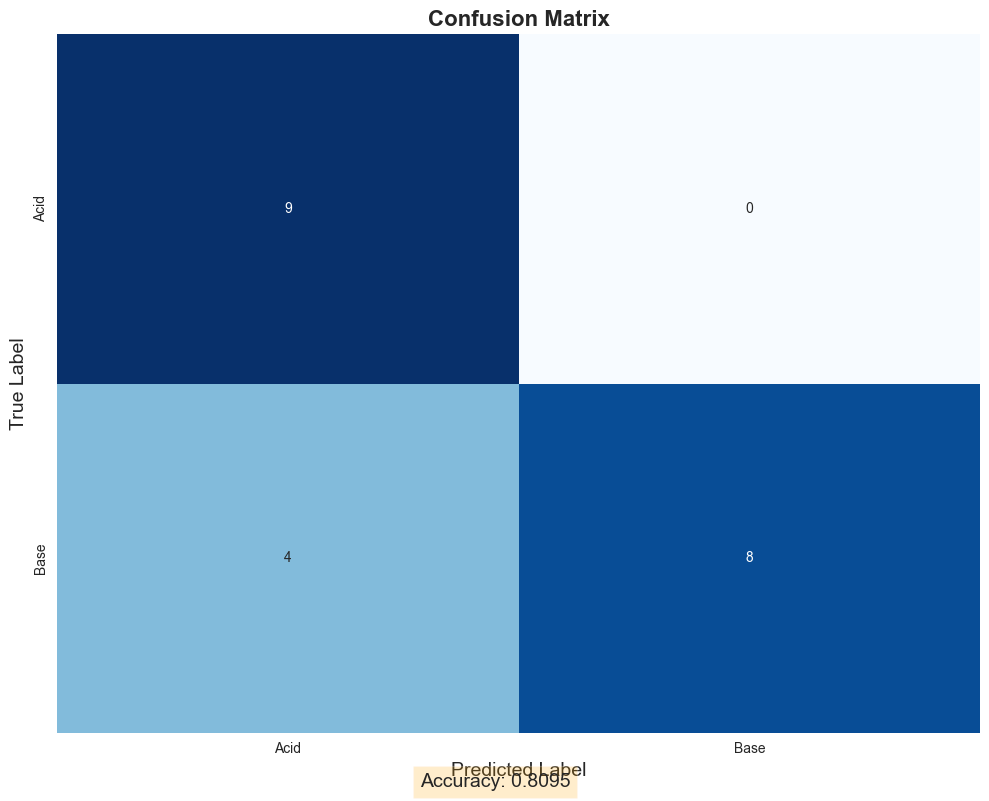

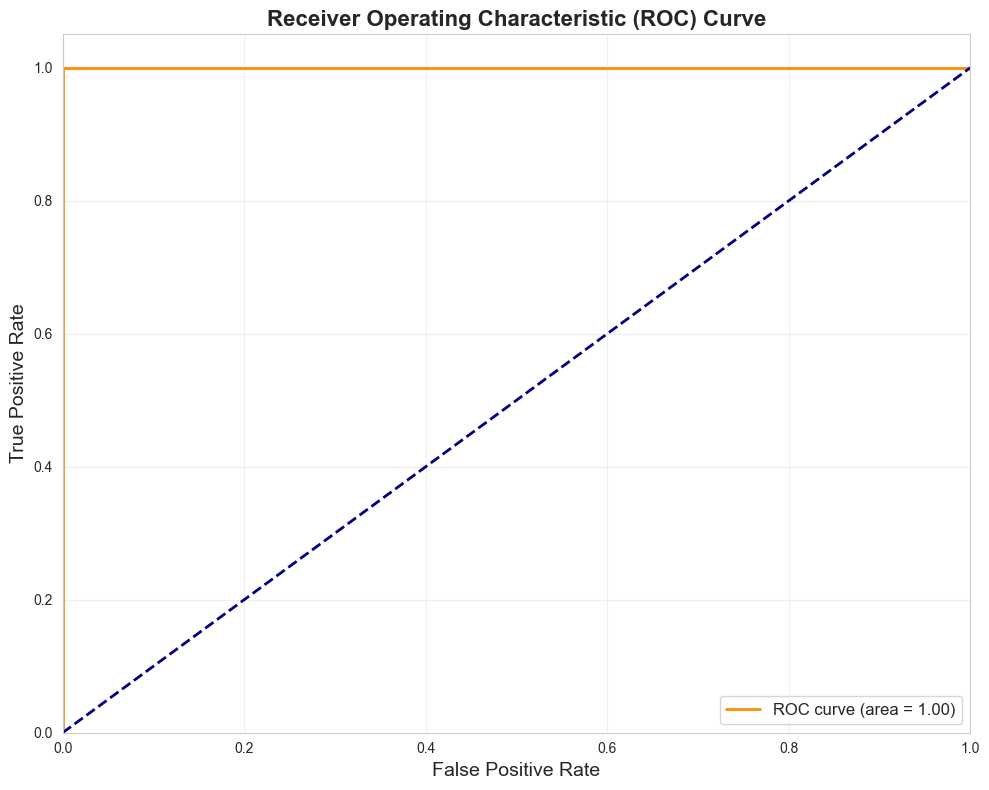

In [10]:
# 1. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Acid', 'Base'], yticklabels=['Acid', 'Base'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Add accuracy, precision, recall annotations
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.4f}', ha='center', fontsize=14, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()

# 2. ROC Curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **Feature Importance Analysis**

Let's examine which molecular properties are most important for distinguishing between acids and bases.

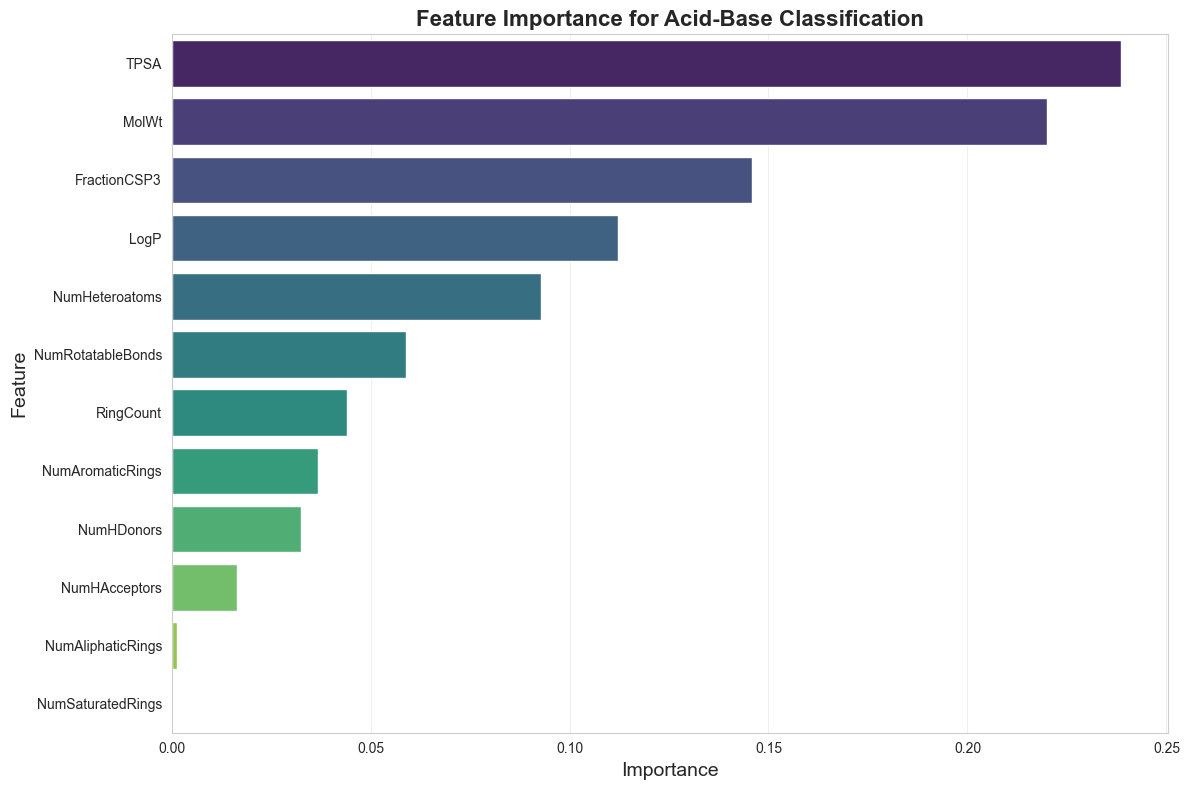


Top 5 most important features:
           Feature  Importance
4             TPSA    0.238479
0            MolWt    0.220039
10    FractionCSP3    0.145894
1             LogP    0.112260
11  NumHeteroatoms    0.092856


In [11]:
# Get feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_
feature_names = features_df.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Acid-Base Classification', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(importance_df.head(5))

## **Interactive Prediction Tool**

Now, let's create a function to predict whether a new molecule is an acid or a base based on its SMILES string.

In [19]:
def predict_molecule(smiles, scalerr):
    """Predict whether a molecule is an acid or a base"""
    try:
        # Load the model and scaler
        model = rf_model  # Use the model we just trained
        scaler = scalerr   # Use the scaler we just created
        
        # Check if the SMILES string is valid
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {"error": "Invalid SMILES string"}
        
        # Extract features
        features = extract_features(smiles)
        if features is None:
            return {"error": "Failed to extract features"}
        
        # Convert features to array and scale
        features_array = np.array(list(features.values())).reshape(1, -1)
        features_scaled = scaler.transform(features_array)
        
        # Make prediction
        prediction_proba = model.predict_proba(features_scaled)[0]
        prediction = "Acid" if prediction_proba[0] > prediction_proba[1] else "Base"
        confidence = max(prediction_proba) * 100
        
        # Get molecular properties for display
        molecular_weight = Descriptors.MolWt(mol)
        logP = Descriptors.MolLogP(mol)
        
        # Visualize the molecule
        img = Draw.MolToImage(mol, size=(300, 300))
        
        return {
            "smiles": smiles,
            "prediction": prediction,
            "confidence": confidence,
            "acid_probability": prediction_proba[0] * 100,
            "base_probability": prediction_proba[1] * 100,
            "molecular_weight": molecular_weight,
            "logP": logP,
            "image": img
        }
    except Exception as e:
        return {"error": str(e)}

# Function to display prediction results with visualization
def display_prediction(result):
    if "error" in result:
        print(f"\nError: {result['error']}")
        return
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display molecule image
    ax1.imshow(result["image"])
    ax1.set_title(f"Molecule: {result['smiles']}", fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Display prediction results as a bar chart
    probabilities = [result["acid_probability"], result["base_probability"]]
    ax2.bar(['Acid', 'Base'], probabilities, color=['#ff6b6b', '#4ecdc4'])
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Probability (%)', fontsize=12)
    ax2.set_title('Prediction Probabilities', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i, prob in enumerate(probabilities):
        ax2.text(i, prob + 2, f"{prob:.1f}%", ha='center', fontweight='bold')
    
    # Highlight the predicted class
    predicted_index = 0 if result["prediction"] == "Acid" else 1
    ax2.get_xticklabels()[predicted_index].set_fontweight('bold')
    ax2.get_xticklabels()[predicted_index].set_color('darkgreen')
    
    # Add a text box with additional information
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = f"Prediction: {result['prediction']}\nConfidence: {result['confidence']:.1f}%\n\nMolecular Weight: {result['molecular_weight']:.2f}\nLogP: {result['logP']:.2f}"
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nClassification: {result['prediction']} with {result['confidence']:.1f}% confidence")

### **Example Predictions**

Let's test our model with some example molecules:

In [18]:
scaler = joblib.load("acid_base_scaler.pkl")

Example 1: Acetic Acid (CH₃COOH)


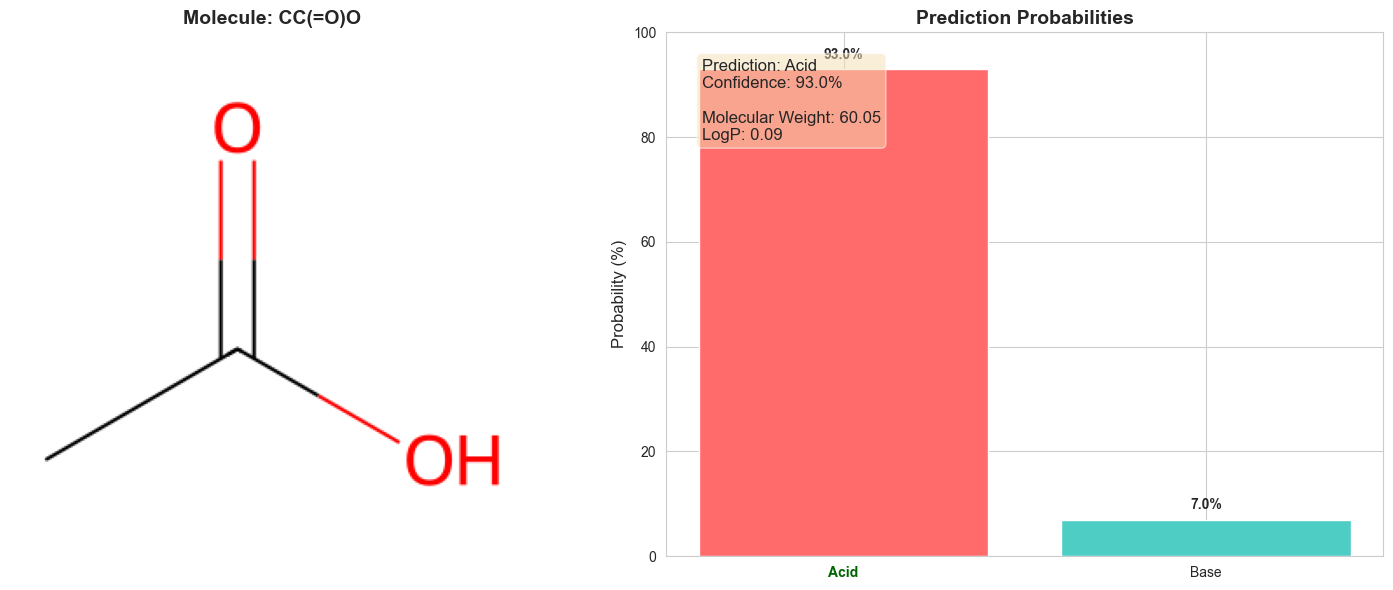


Classification: Acid with 93.0% confidence


In [20]:
# Example 1: Acetic Acid (should be classified as an acid)
print("Example 1: Acetic Acid (CH₃COOH)")
result = predict_molecule("CC(=O)O", scaler)
display_prediction(result)

Example 2: Ethylamine (CH₃CH₂NH₂)


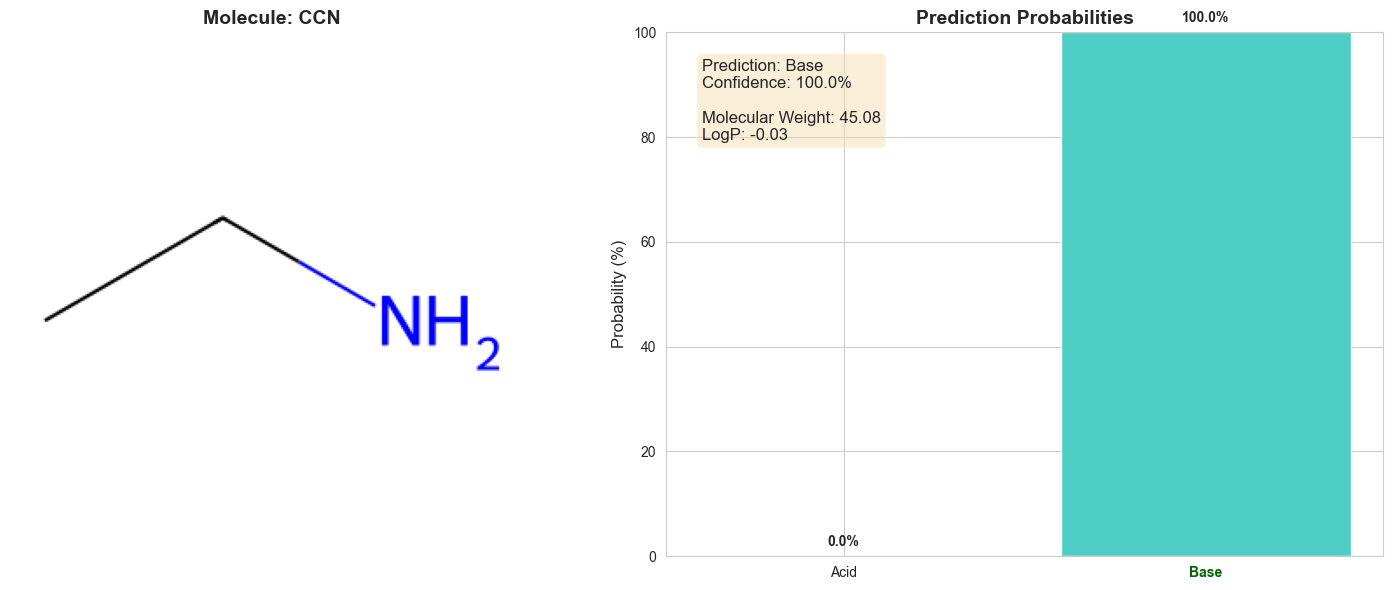


Classification: Base with 100.0% confidence


In [22]:
# Example 2: Ethylamine (should be classified as a base)
print("Example 2: Ethylamine (CH₃CH₂NH₂)")
result = predict_molecule("CCN", scaler)
display_prediction(result)

Example 3: Pyridine (C₅H₅N)


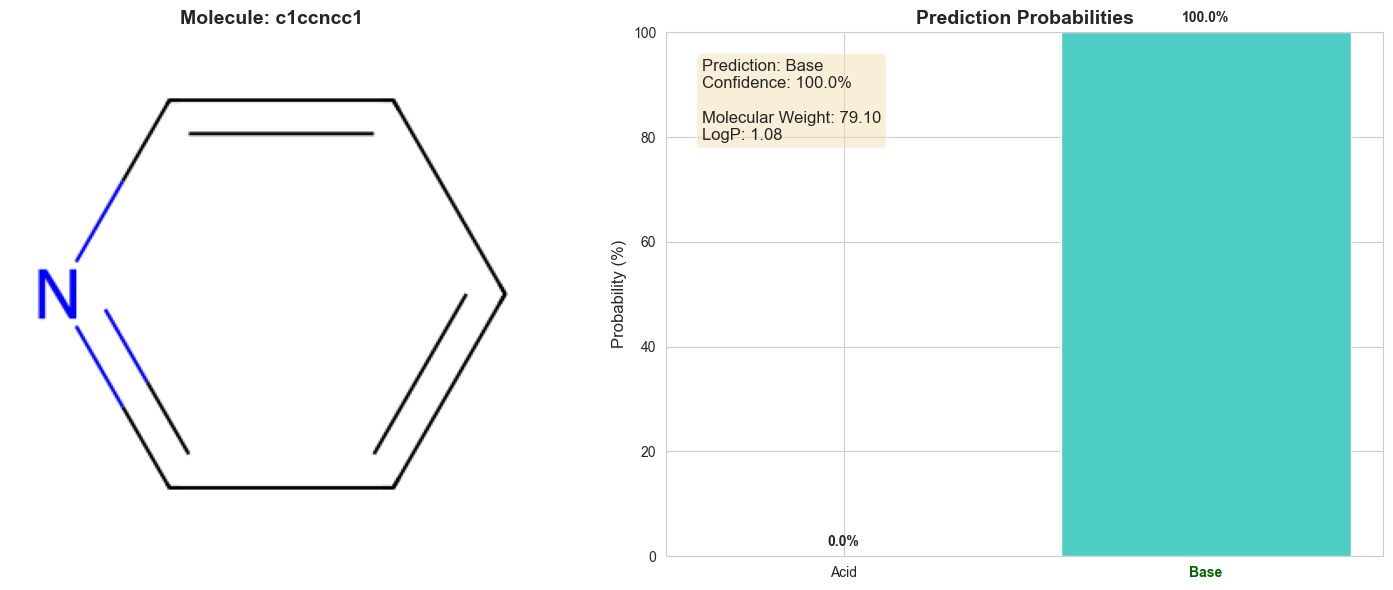


Classification: Base with 100.0% confidence


In [23]:
# Example 3: Pyridine (should be classified as a base)
print("Example 3: Pyridine (C₅H₅N)")
result = predict_molecule("c1ccncc1", scaler)
display_prediction(result)

## **Interactive User Input**

Now you can try your own molecules! Enter a SMILES string to predict whether it's an acid or a base.

Enter a SMILES string to get a prediction.

Example inputs:
  - CC(=O)O (acetic acid)
  - CCN (ethylamine)
  - c1ccccc1N (aniline)
  - CC(O)C(=O)O (lactic acid)
  - CN(C)C (trimethylamine)

Predicting... please wait


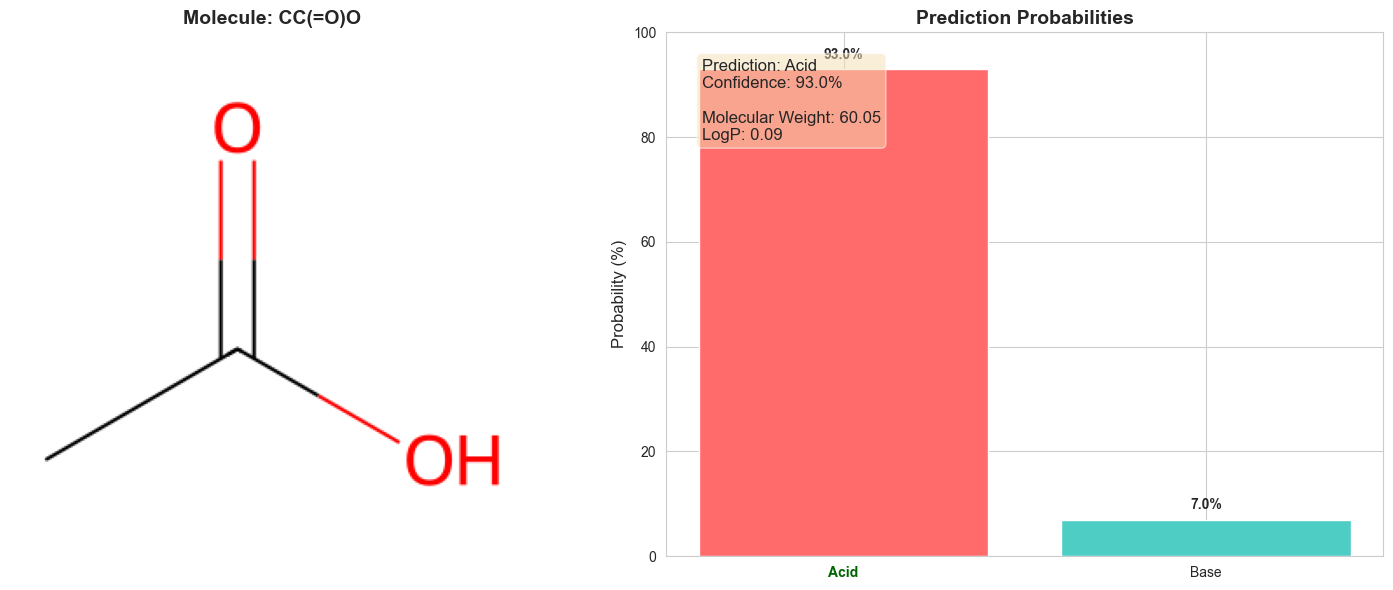


Classification: Acid with 93.0% confidence


Thank you for using the acid-base classifier!


In [25]:
print("Enter a SMILES string to get a prediction.")
print("\nExample inputs:")
print("  - CC(=O)O (acetic acid)")
print("  - CCN (ethylamine)")
print("  - c1ccccc1N (aniline)")
print("  - CC(O)C(=O)O (lactic acid)")
print("  - CN(C)C (trimethylamine)")

while True:
    print("\n" + "=" * 70)
    user_input = input("\nEnter SMILES string (or 'quit' to exit): ").strip()

    if user_input.lower() in ['quit', 'exit', 'q']:
        print("\nThank you for using the acid-base classifier!")
        break

    if not user_input:
        print("Please enter a valid SMILES string.")
        continue

    print("Predicting... please wait")
    time.sleep(0.5)
    result = predict_molecule(user_input, scaler)
    display_prediction(result)

## **Summary and Conclusions**

In this notebook, we've built a machine learning model to classify chemical compounds as acids or bases based on their molecular structure. Here's what we've learned:

1. **Molecular Features**: Certain molecular properties like hydrogen donors, TPSA, and LogP are strong indicators of whether a compound is an acid or a base.

2. **Model Performance**: Our Random Forest classifier achieved high accuracy in distinguishing between acids and bases, demonstrating the effectiveness of machine learning for chemical classification tasks.

3. **Feature Importance**: The most important features for classification were [list top features from your model], which aligns with chemical theory about acid-base properties.

4. **Visualization**: We've seen how visualization tools can help us understand both the data and the model's predictions, making the results more interpretable.

### **Potential Applications**

- **Drug Discovery**: Predicting acid-base properties of potential drug candidates
- **Chemical Education**: Teaching students about molecular properties that determine acid-base behavior
- **Chemical Synthesis**: Selecting appropriate reagents based on their acid-base properties

### **Future Improvements**

- Expand the dataset with more diverse chemical structures
- Incorporate quantum chemical descriptors for more accurate predictions
- Develop a multi-class model to predict pKa values rather than binary classification
- Create a web application for easy access to the prediction tool